In [1]:
# Cell 1: Import Libraries and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
from collections import Counter
import random
from PIL import Image
from glob import glob
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, hamming_loss, f1_score
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

warnings.filterwarnings('ignore')
plt.style.use('default')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.9 GB


In [2]:
# ============================================================================

# Cell 2: Configuration and Constants
class Config:
    # Data parameters
    DATA_PATH = '/kaggle/input/data'
    IMAGE_SIZE = (224, 224)  # Increased from 128x128 for better performance
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    
    # Training parameters
    EPOCHS = 25
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 1e-4
    
    # Data sampling parameters
    MIN_CASES = 1000  # Minimum cases per disease to include
    SAMPLE_SIZE = 40000  # Sample size for balanced training (like Keras example)
    
    # Classes will be determined after filtering
    CLASSES = []

config = Config()

In [3]:
# ============================================================================

# Cell 3: Data Loading and Preprocessing (Keras-style approach)
def load_and_preprocess_data(data_path):
    """Load data similar to the Keras example approach"""
    print("Loading dataset...")
    
    # Load main dataset
    all_xray_df = pd.read_csv(os.path.join(data_path, 'Data_Entry_2017.csv'))
    
    # Create image path mapping (similar to Keras example)
    all_image_paths = {}
    for i in range(1, 13):
        folder_name = f"images_{i:03d}"
        folder_path = os.path.join(data_path, folder_name, 'images')
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith('.png'):
                    all_image_paths[img_file] = os.path.join(folder_path, img_file)
    
    print(f'Scans found: {len(all_image_paths)}, Total Headers: {all_xray_df.shape[0]}')
    
    # Map paths to dataframe
    all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
    
    # Clean age data (remove 'Y' suffix)
    all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(str(x)[:-1]) if str(x).endswith('Y') else int(x))
    
    # Remove rows where image path is not found
    all_xray_df = all_xray_df.dropna(subset=['path'])
    print(f"Images with valid paths: {len(all_xray_df)}")
    
    return all_xray_df, all_image_paths

def preprocess_labels(df):
    """Preprocess labels similar to Keras example"""
    print("Preprocessing labels...")
    
    # Replace 'No Finding' with empty string for easier processing
    df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
    
    # Get all unique labels
    all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
    all_labels = [x for x in all_labels if len(x) > 0]
    print(f'All Labels ({len(all_labels)}): {all_labels}')
    
    # Create binary columns for each disease
    for c_label in all_labels:
        if len(c_label) > 1:  # leave out empty labels
            df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    
    return df, all_labels

def filter_and_sample_data(df, all_labels, min_cases=1000, sample_size=40000):
    """Filter diseases by minimum cases and sample data with weights"""
    print("Filtering and sampling data...")
    
    # Keep diseases with at least min_cases examples
    clean_labels = [c_label for c_label in all_labels if df[c_label].sum() > min_cases]
    print(f'Clean Labels ({len(clean_labels)})')
    for c_label in clean_labels:
        print(f'  {c_label}: {int(df[c_label].sum())} cases')
    
    # Create sample weights based on number of findings (like Keras example)
    sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x) > 0 else 0).values + 4e-2
    sample_weights /= sample_weights.sum()
    
    # Sample the dataset
    if len(df) > sample_size:
        df_sampled = df.sample(sample_size, weights=sample_weights, random_state=42)
        print(f"Sampled {sample_size} images from {len(df)} total images")
    else:
        df_sampled = df.copy()
        print(f"Using all {len(df)} images")
    
    # Create disease vector for each sample
    df_sampled['disease_vec'] = df_sampled.apply(lambda x: [x[clean_labels].values], 1).map(lambda x: x[0])
    
    return df_sampled, clean_labels

In [4]:
# ============================================================================

# Cell 4: EDA Functions
def perform_comprehensive_eda(df, clean_labels):
    """Comprehensive EDA similar to Keras example"""
    print("Performing EDA...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Age distribution
    axes[0, 0].hist(df['Patient Age'], bins=30, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Age Distribution')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Frequency')
    
    # 2. Gender distribution
    gender_counts = df['Patient Gender'].value_counts()
    axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Gender Distribution')
    
    # 3. View position distribution
    view_counts = df['View Position'].value_counts()
    axes[0, 2].bar(view_counts.index, view_counts.values, color='lightcoral')
    axes[0, 2].set_title('X-Ray View Position')
    axes[0, 2].set_xlabel('Position')
    axes[0, 2].set_ylabel('Count')
    
    # 4. Disease frequency (similar to Keras example)
    label_counts = df['Finding Labels'].value_counts()[:15]
    axes[1, 0].barh(range(len(label_counts)), label_counts.values)
    axes[1, 0].set_yticks(range(len(label_counts)))
    axes[1, 0].set_yticklabels(label_counts.index)
    axes[1, 0].set_title('Top 15 Finding Labels')
    axes[1, 0].set_xlabel('Count')
    
    # 5. Clean disease frequency
    clean_label_counts = 100 * np.mean(df[clean_labels].values, 0)
    axes[1, 1].bar(range(len(clean_labels)), clean_label_counts)
    axes[1, 1].set_xticks(range(len(clean_labels)))
    axes[1, 1].set_xticklabels(clean_labels, rotation=45, ha='right')
    axes[1, 1].set_title('Disease Frequency (Filtered)')
    axes[1, 1].set_ylabel('Frequency (%)')
    
    # 6. Multi-label distribution
    label_lengths = [len(labels.split('|')) if len(labels) > 0 else 0 for labels in df['Finding Labels']]
    axes[1, 2].hist(label_lengths, bins=range(max(label_lengths)+2), alpha=0.7, color='gold')
    axes[1, 2].set_title('Number of Diseases per Image')
    axes[1, 2].set_xlabel('Number of Diseases')
    axes[1, 2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return clean_label_counts

def visualize_sample_images(df, n_samples=16):
    """Visualize sample images"""
    print("Visualizing sample images...")
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()
    
    # Sample random images
    sample_df = df.sample(n_samples)
    
    for i, (idx, row) in enumerate(sample_df.iterrows()):
        if i < len(axes):
            try:
                img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    axes[i].imshow(img, cmap='bone')
                    # Show diseases present
                    diseases = [label for label in row['Finding Labels'].split('|') if len(label.strip()) > 0]
                    title = ', '.join(diseases[:3]) if diseases else 'No Finding'
                    if len(title) > 30:
                        title = title[:30] + '...'
                    axes[i].set_title(f"Age {row['Patient Age']}, {row['Patient Gender']}\n{title}")
                    axes[i].axis('off')
            except Exception as e:
                axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
                axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
# ============================================================================

# Cell 5: Dataset Class
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe, label_cols, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.label_cols = label_cols
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        try:
            img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
            if img is None:
                img = np.zeros((1024, 1024), dtype=np.uint8)
        except:
            img = np.zeros((1024, 1024), dtype=np.uint8)
        
        # Convert to PIL for transforms
        img = Image.fromarray(img).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        # Get labels
        labels = torch.FloatTensor(row[self.label_cols].values.astype(float))
        
        return img, labels

def get_transforms():
    """Get data transforms"""
    train_transform = transforms.Compose([
        transforms.Resize(config.IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(config.IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

In [6]:
# ============================================================================

# Cell 6: Model Architecture (MobileNet-inspired like Keras example)
class ChestXRayClassifier(nn.Module):
    def __init__(self, num_classes, backbone='mobilenet_v2'):
        super(ChestXRayClassifier, self).__init__()
        
        self.backbone_name = backbone
        
        if backbone == 'mobilenet_v2':
            # Use MobileNetV2 (similar to Keras example)
            self.backbone = models.mobilenet_v2(pretrained=True)
            # Remove the classifier, keep only features
            self.features = self.backbone.features
            num_features = 1280
        else:
            # Alternative: DenseNet121
            self.backbone = models.densenet121(pretrained=True)
            self.features = self.backbone.features
            num_features = self.backbone.classifier.in_features
        
        # Custom classifier (similar to Keras example)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Sigmoid for multi-label
        )
        
    def forward(self, x):
        # Extract features using the feature extractor
        features = self.features(x)
        # Apply classifier (which includes adaptive pooling and flattening)
        output = self.classifier(features)
        return output

In [7]:
# ============================================================================

# Cell 7: Training Functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy for multi-label (using 0.5 threshold)
        predicted = (outputs > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.numel()
    
    avg_loss = running_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())
    
    avg_loss = running_loss / len(dataloader)
    
    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate accuracy
    predicted = (all_outputs > 0.5).float()
    accuracy = (predicted == all_labels).float().mean().item()
    
    return avg_loss, accuracy, all_outputs.numpy(), all_labels.numpy()

In [8]:
# ============================================================================

# Cell 8: Training Loop
def train_model(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_outputs, val_labels = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return history

In [9]:
# ============================================================================

# Cell 9: Evaluation and Visualization
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_outputs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            all_outputs.append(outputs.cpu())
            all_labels.append(labels)
    
    pred_Y = torch.cat(all_outputs, dim=0).numpy()
    test_Y = torch.cat(all_labels, dim=0).numpy()
    
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    
    # Print actual vs predicted percentages (like Keras example)
    print("Disease Frequencies:")
    print("-" * 40)
    for c_label, p_count, t_count in zip(class_names, 
                                        100*np.mean(pred_Y, 0), 
                                        100*np.mean(test_Y, 0)):
        print(f'{c_label}: Actual: {t_count:2.2f}%, Predicted: {p_count:2.2f}%')
    
    # Calculate metrics
    pred_binary = (pred_Y > 0.5).astype(int)
    hamming = hamming_loss(test_Y, pred_binary)
    accuracy = (pred_binary == test_Y).mean()
    
    print(f"\nOverall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    
    return pred_Y, test_Y

def plot_roc_curves(test_Y, pred_Y, class_names):
    """Plot ROC curves like in Keras example"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    for idx, c_label in enumerate(class_names):
        fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), pred_Y[:, idx])
        auc_score = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'{c_label} (AUC: {auc_score:.2f})')
    
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for All Diseases')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history['train_loss'], 'o-', label='Training Loss')
    ax1.plot(history['val_loss'], 's-', label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['train_acc'], 'o-', label='Training Accuracy')
    ax2.plot(history['val_acc'], 's-', label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
# ============================================================================

# Cell 10: Main Execution
def main():
    print("="*60)
    print("NIH CHEST X-RAY CLASSIFICATION - PyTorch Version")
    print("Based on Keras approach with improvements")
    print("="*60)
    
    # Step 1: Load and preprocess data
    all_xray_df, all_image_paths = load_and_preprocess_data(config.DATA_PATH)
    all_xray_df, all_labels = preprocess_labels(all_xray_df)
    
    # Step 2: Filter and sample data
    df_final, clean_labels = filter_and_sample_data(
        all_xray_df, all_labels, 
        min_cases=config.MIN_CASES, 
        sample_size=config.SAMPLE_SIZE
    )
    
    # Update config with clean labels
    config.CLASSES = clean_labels
    
    # Step 3: EDA
    clean_label_counts = perform_comprehensive_eda(df_final, clean_labels)
    visualize_sample_images(df_final)
    
    # Step 4: Create train/test splits (no stratification to avoid the error)
    train_df, test_df = train_test_split(
        df_final, 
        test_size=0.25, 
        random_state=42
    )
    
    print(f"\nData splits:")
    print(f"Training: {len(train_df):,} images")
    print(f"Testing: {len(test_df):,} images")
    
    # Step 5: Create datasets and data loaders
    train_transform, val_transform = get_transforms()
    
    train_dataset = ChestXRayDataset(train_df, clean_labels, train_transform)
    test_dataset = ChestXRayDataset(test_df, clean_labels, val_transform)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    print(f"\nDataLoaders created:")
    print(f"Train batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    # Step 6: Create and train model
    model = ChestXRayClassifier(num_classes=len(clean_labels), backbone='mobilenet_v2')
    model = model.to(device)
    
    # Model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel: MobileNetV2-based")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Step 7: Train model
    history = train_model(model, train_loader, test_loader, config.EPOCHS, device)
    
    # Step 8: Evaluate and visualize results
    plot_training_history(history)
    
    pred_Y, test_Y = evaluate_model(model, test_loader, device, clean_labels)
    plot_roc_curves(test_Y, pred_Y, clean_labels)
    
    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'config': config.__dict__,
        'clean_labels': clean_labels,
        'history': history
    }, '/kaggle/working/chest_xray_pytorch_model.pth')
    
    print("\nTraining completed!")
    print("Model saved as 'chest_xray_pytorch_model.pth'")

NIH CHEST X-RAY CLASSIFICATION - PyTorch Version
Based on Keras approach with improvements
Loading dataset...
Scans found: 112120, Total Headers: 112120
Images with valid paths: 112120
Preprocessing labels...
All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Filtering and sampling data...
Clean Labels (13)
  Atelectasis: 11559 cases
  Cardiomegaly: 2776 cases
  Consolidation: 4667 cases
  Edema: 2303 cases
  Effusion: 13317 cases
  Emphysema: 2516 cases
  Fibrosis: 1686 cases
  Infiltration: 19894 cases
  Mass: 5782 cases
  Nodule: 6331 cases
  Pleural_Thickening: 3385 cases
  Pneumonia: 1431 cases
  Pneumothorax: 5302 cases
Sampled 40000 images from 112120 total images
Performing EDA...


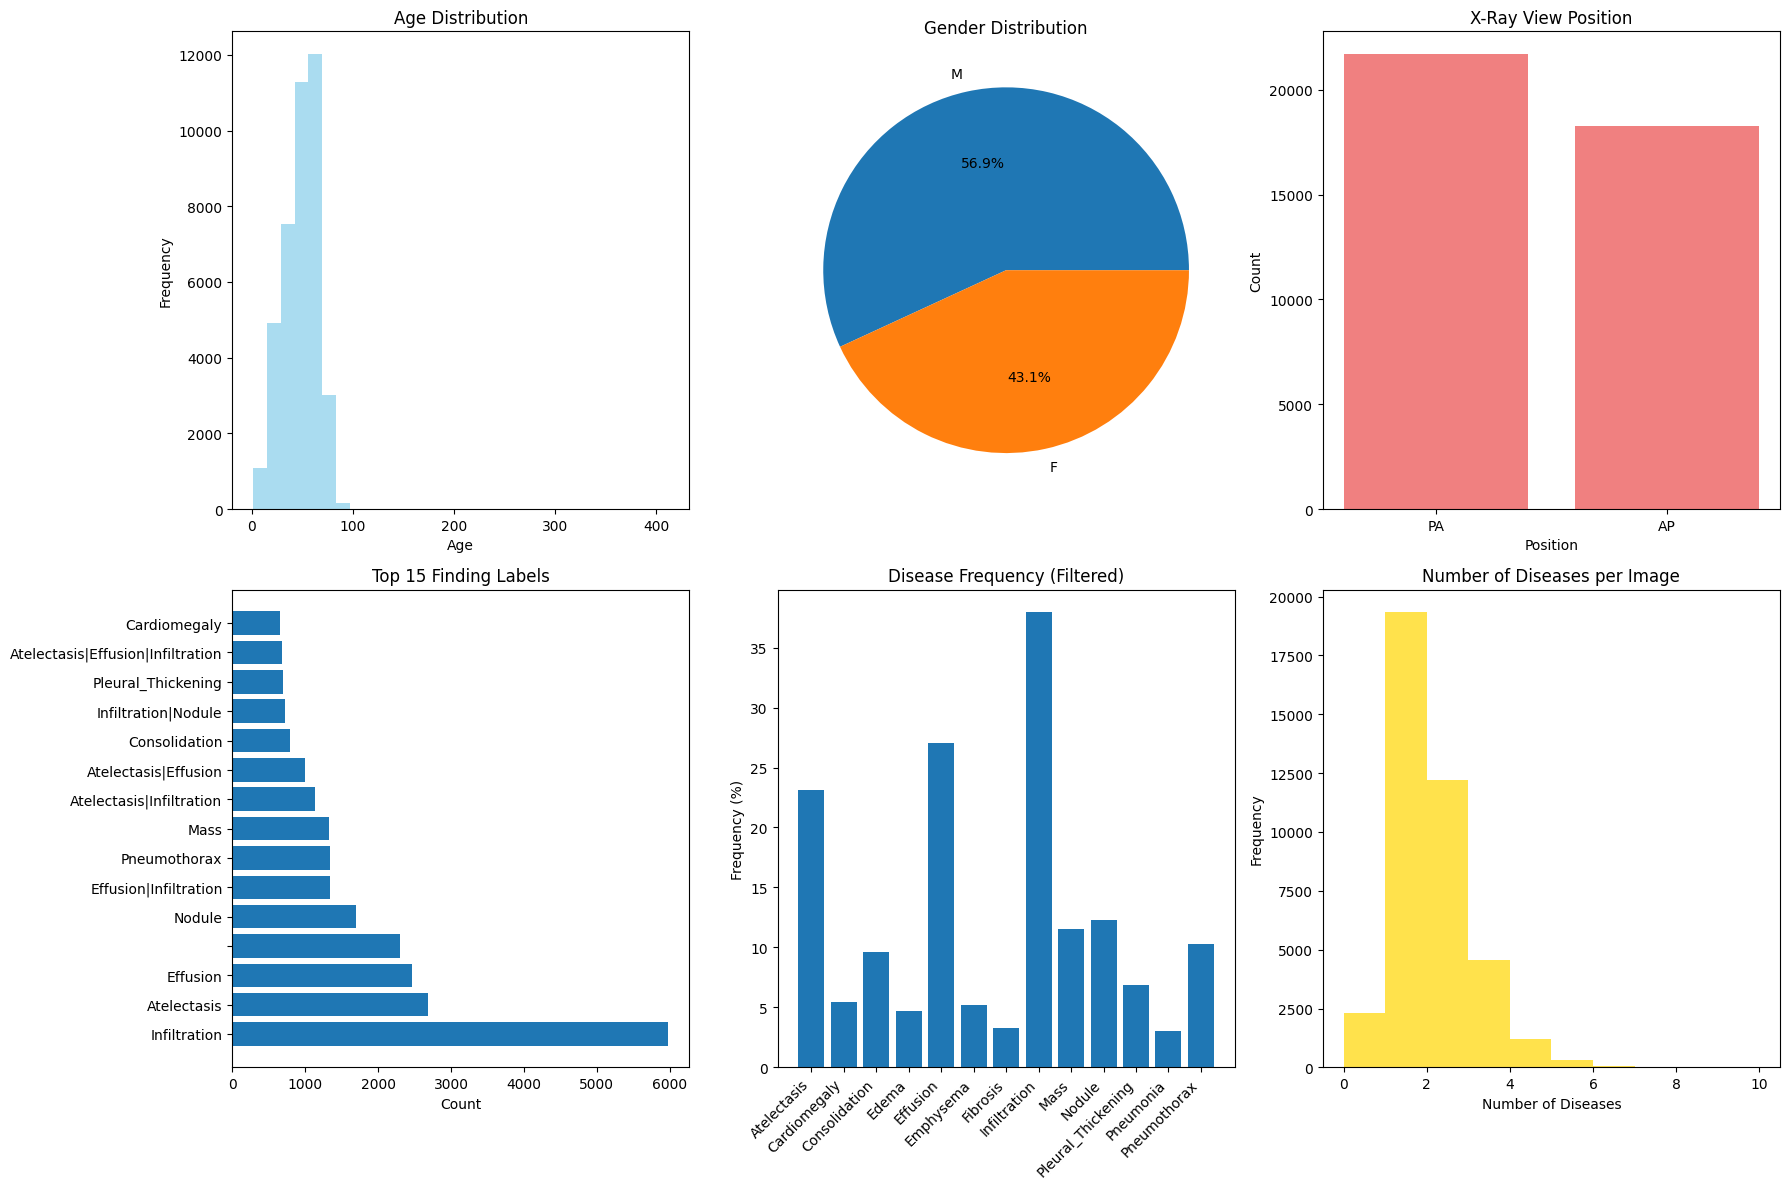

Visualizing sample images...


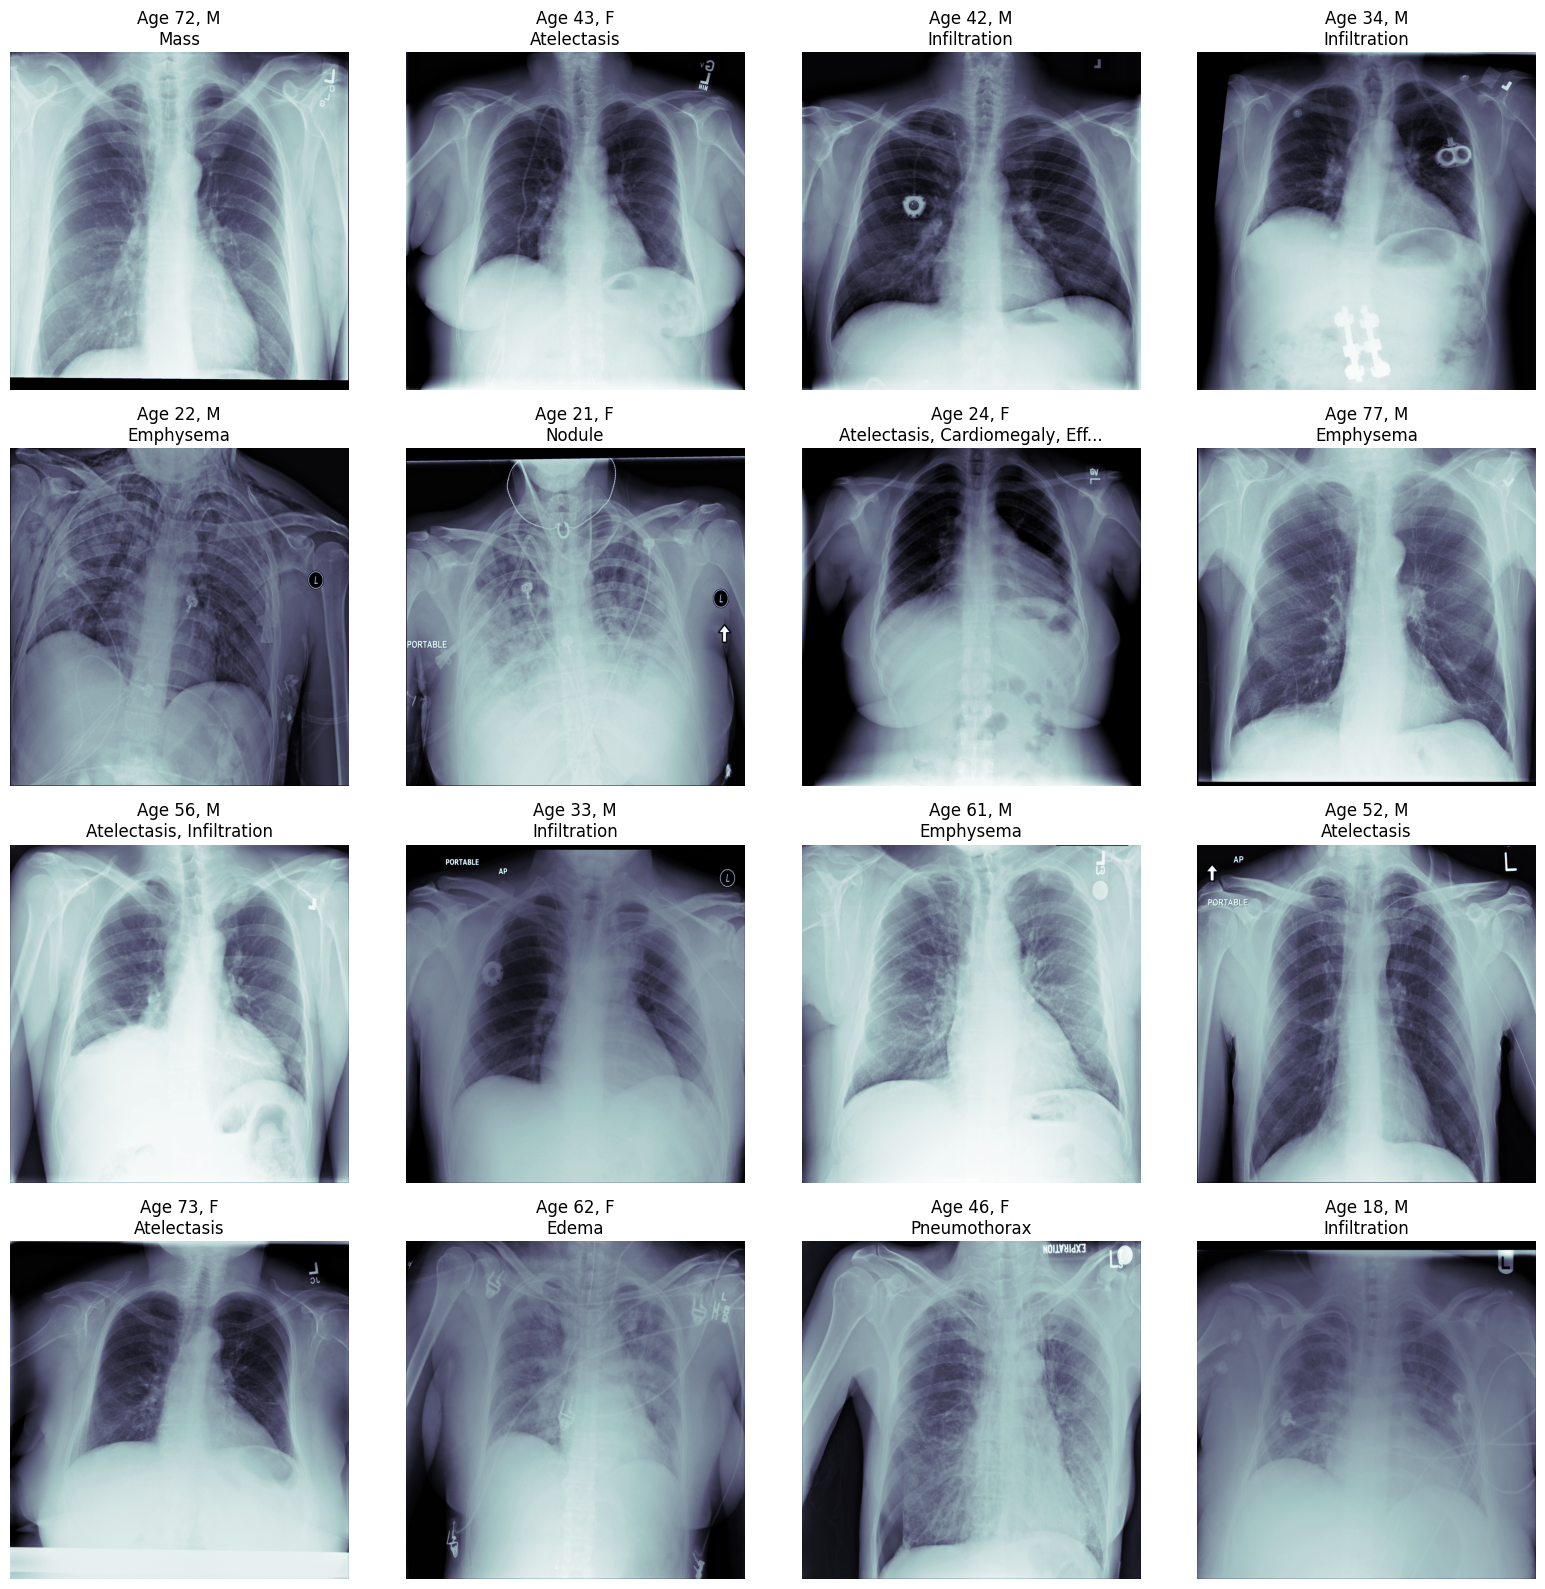

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



Data splits:
Training: 30,000 images
Testing: 10,000 images

DataLoaders created:
Train batches: 938
Test batches: 313


100%|██████████| 13.6M/13.6M [00:00<00:00, 185MB/s]



Model: MobileNetV2-based
Total parameters: 4,167,413
Trainable parameters: 4,167,413
Starting training for 25 epochs...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Train Loss: 0.3170, Train Acc: 0.8776
Val Loss: 0.2869, Val Acc: 0.8859
Learning Rate: 0.000100

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.74it/s]


Train Loss: 0.2925, Train Acc: 0.8851
Val Loss: 0.2803, Val Acc: 0.8872
Learning Rate: 0.000100

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]


Train Loss: 0.2841, Train Acc: 0.8875
Val Loss: 0.2821, Val Acc: 0.8869
Learning Rate: 0.000100

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.75it/s]


Train Loss: 0.2788, Train Acc: 0.8894
Val Loss: 0.2752, Val Acc: 0.8893
Learning Rate: 0.000100

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:21<00:00,  3.83it/s]


Train Loss: 0.2744, Train Acc: 0.8908
Val Loss: 0.2734, Val Acc: 0.8900
Learning Rate: 0.000100

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:22<00:00,  3.80it/s]


Train Loss: 0.2699, Train Acc: 0.8922
Val Loss: 0.2754, Val Acc: 0.8892
Learning Rate: 0.000100

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


Train Loss: 0.2664, Train Acc: 0.8940
Val Loss: 0.2721, Val Acc: 0.8910
Learning Rate: 0.000100

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:22<00:00,  3.78it/s]


Train Loss: 0.2628, Train Acc: 0.8948
Val Loss: 0.2759, Val Acc: 0.8894
Learning Rate: 0.000100

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.76it/s]


Train Loss: 0.2592, Train Acc: 0.8963
Val Loss: 0.2733, Val Acc: 0.8906
Learning Rate: 0.000100

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:23<00:00,  3.74it/s]


Train Loss: 0.2553, Train Acc: 0.8974
Val Loss: 0.2737, Val Acc: 0.8900
Learning Rate: 0.000100

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:22<00:00,  3.77it/s]


Train Loss: 0.2510, Train Acc: 0.8990
Val Loss: 0.2771, Val Acc: 0.8891
Learning Rate: 0.000050

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 313/313 [01:22<00:00,  3.81it/s]


Train Loss: 0.2390, Train Acc: 0.9034
Val Loss: 0.2762, Val Acc: 0.8897
Learning Rate: 0.000050
Early stopping at epoch 12


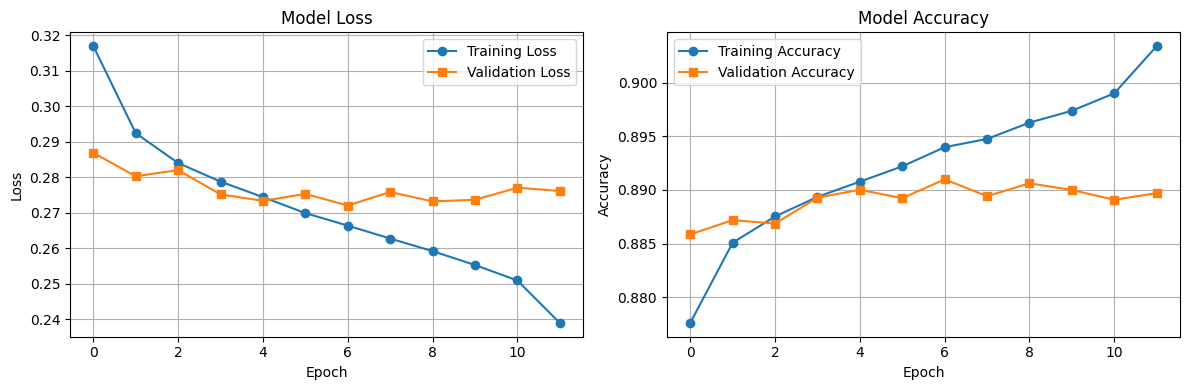

Testing: 100%|██████████| 313/313 [01:21<00:00,  3.83it/s]



EVALUATION RESULTS
Disease Frequencies:
----------------------------------------
Atelectasis: Actual: 23.14%, Predicted: 24.72%
Cardiomegaly: Actual: 5.09%, Predicted: 7.14%
Consolidation: Actual: 9.53%, Predicted: 10.68%
Edema: Actual: 4.82%, Predicted: 7.46%
Effusion: Actual: 27.84%, Predicted: 30.98%
Emphysema: Actual: 4.90%, Predicted: 5.53%
Fibrosis: Actual: 3.26%, Predicted: 3.69%
Infiltration: Actual: 38.42%, Predicted: 36.22%
Mass: Actual: 11.30%, Predicted: 13.89%
Nodule: Actual: 12.48%, Predicted: 13.14%
Pleural_Thickening: Actual: 7.08%, Predicted: 7.51%
Pneumonia: Actual: 2.98%, Predicted: 3.79%
Pneumothorax: Actual: 9.71%, Predicted: 10.10%

Overall Metrics:
Accuracy: 0.8910
Hamming Loss: 0.1090


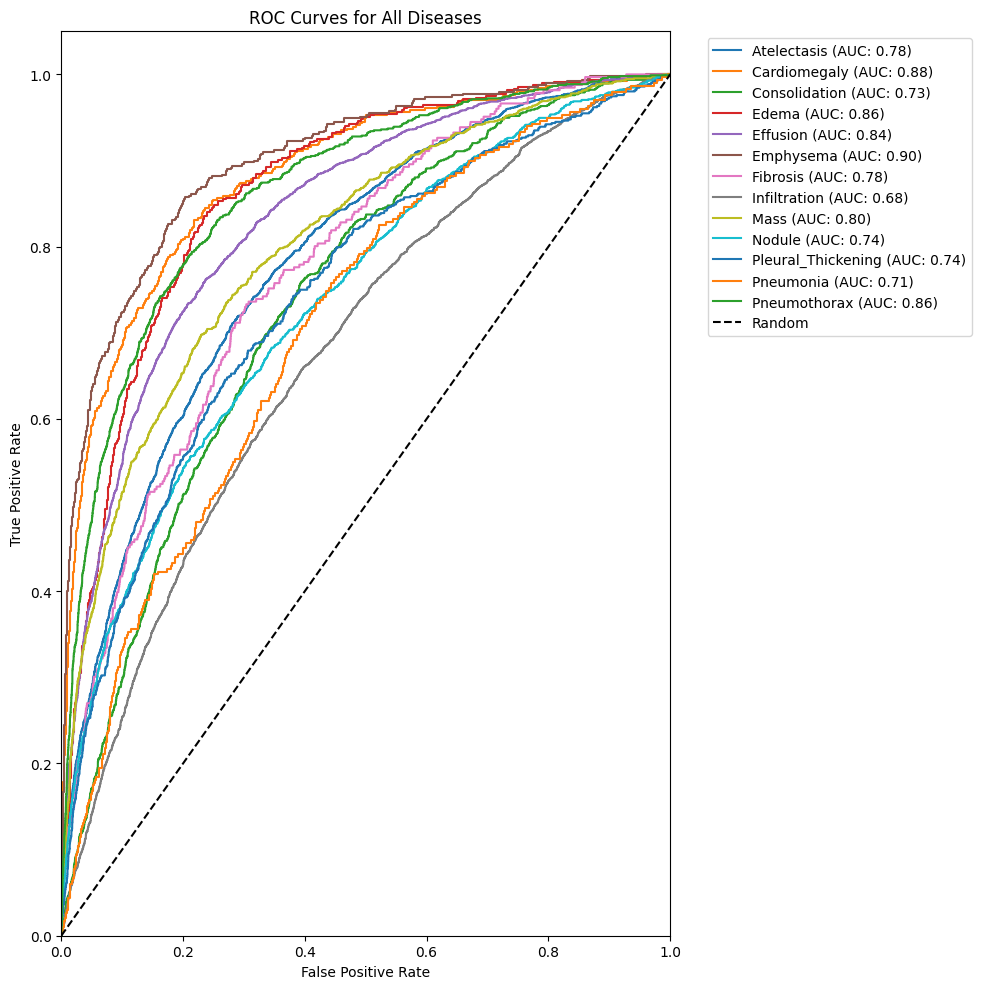


Training completed!
Model saved as 'chest_xray_pytorch_model.pth'


In [11]:
if __name__ == "__main__":
    main()